In [1]:
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.data import Dataset, DataLoader

from src.encoding.configs_and_constants import ZINC_SMILES_HRR_7744_CONFIG_F64
from src.encoding.graph_encoders import load_or_create_hypernet
from src.utils.utils import GLOBAL_MODEL_PATH


def analyze_dataset(ds: Dataset, name: str = "", feature_attr: str = "x") -> dict:
    """
    Compute statistics for a PyG dataset with 4-tuple node features
    and draw histograms for node counts, edge counts, node-type distribution,
    and molecular properties (logp, qed, sa_score, max_ring_size).
    """
    num_nodes_list, num_edges_list = [], []
    node_type_counter = Counter()
    
    # Collect all molecular properties
    property_lists = {
        "logp": [],
        "qed": [],
        "sa_score": [],
        "max_ring_size": []
    }

    for data in ds:
        n = int(data.num_nodes)
        e = int(data.num_edges) // 2  # dataset is undirected
        num_nodes_list.append(n)
        num_edges_list.append(e)

        x: torch.Tensor = getattr(data, feature_attr)
        if x.dim() != 2 or x.size(1) != 5:
            raise ValueError(f"Expected {feature_attr} shape [N, 5], got {tuple(x.shape)}")
        rows = x.detach().cpu().to(torch.int64).tolist()
        node_type_counter.update(map(tuple, rows))

        # Collect molecular properties
        for prop_name in property_lists.keys():
            if hasattr(data, prop_name):
                val = getattr(data, prop_name)
                # Handle scalar tensor or 1-element tensor
                if isinstance(val, torch.Tensor):
                    val = float(val.detach().cpu().reshape(-1)[0])
                else:
                    val = float(val)
                property_lists[prop_name].append(val)

    def stats(arr):
        arr = np.asarray(arr)
        return {
            "min": float(arr.min()),
            "max": float(arr.max()),
            "mean": float(arr.mean()),
            "median": float(np.median(arr)),
            "std": float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        }

    summary = {
        "dataset": name,
        "num_graphs": len(ds),
        "nodes": stats(num_nodes_list),
        "edges": stats(num_edges_list),
        "total_node_types": len(node_type_counter),
        "node_type_distribution": dict(node_type_counter),
    }

    # Add property stats if available
    for prop_name, prop_list in property_lists.items():
        if prop_list:
            summary[prop_name] = stats(prop_list)

    # --- Plotting: Graph structure ---
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 3])

    ax_nodes = fig.add_subplot(gs[0, 0])
    ax_edges = fig.add_subplot(gs[0, 1])
    ax_types = fig.add_subplot(gs[1, :])

    plt.subplots_adjust(bottom=0.25)

    # Node count distribution
    ax_nodes.hist(num_nodes_list, bins=20, color="steelblue", edgecolor="black")
    ax_nodes.set_title(f"{name} – Node count distribution")
    ax_nodes.set_xlabel("num_nodes")
    ax_nodes.set_ylabel("frequency")

    # Edge count distribution
    ax_edges.hist(num_edges_list, bins=40, color="darkorange", edgecolor="black")
    ax_edges.set_title(f"{name} – Edge count distribution")
    ax_edges.set_xlabel("num_edges")
    ax_edges.set_ylabel("frequency")

    # Node type distribution
    if node_type_counter:
        labels, counts = zip(*node_type_counter.most_common())
        ax_types.bar(range(len(labels)), counts, color="seagreen", edgecolor="black")
        ax_types.set_xticks(range(len(labels)))
        ax_types.set_xticklabels([str(l) for l in labels], rotation=90, fontsize=8)
    ax_types.set_title(f"{name} – Node type distribution")
    ax_types.set_xlabel("node type (tuple)")
    ax_types.set_ylabel("count")

    plt.tight_layout()
    plt.show()

    # --- Plotting: Molecular properties (2x2 grid) ---
    available_props = [(name, vals) for name, vals in property_lists.items() if vals]
    
    if available_props:
        fig2, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        # Property display config
        prop_config = {
            "logp": {"color": "purple", "bins": 100, "label": "cLogP (RDKit)"},
            "qed": {"color": "teal", "bins": 50, "label": "QED"},
            "sa_score": {"color": "crimson", "bins": 50, "label": "SA Score"},
            "max_ring_size": {"color": "navy", "bins": 15, "label": "Max Ring Size"}
        }
        
        for idx, (prop_name, prop_list) in enumerate(available_props):
            if idx < 4:  # Only plot first 4 properties
                config = prop_config.get(prop_name, {"color": "gray", "bins": 50, "label": prop_name})
                axes[idx].hist(prop_list, bins=config["bins"], 
                              color=config["color"], edgecolor="black", alpha=0.7)
                axes[idx].set_title(f"{name} – {config['label']} distribution")
                axes[idx].set_xlabel(config["label"])
                axes[idx].set_ylabel("frequency")
                axes[idx].grid(alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(available_props), 4):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

    return summary

/home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/torch_scatter/_version_cuda.so
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


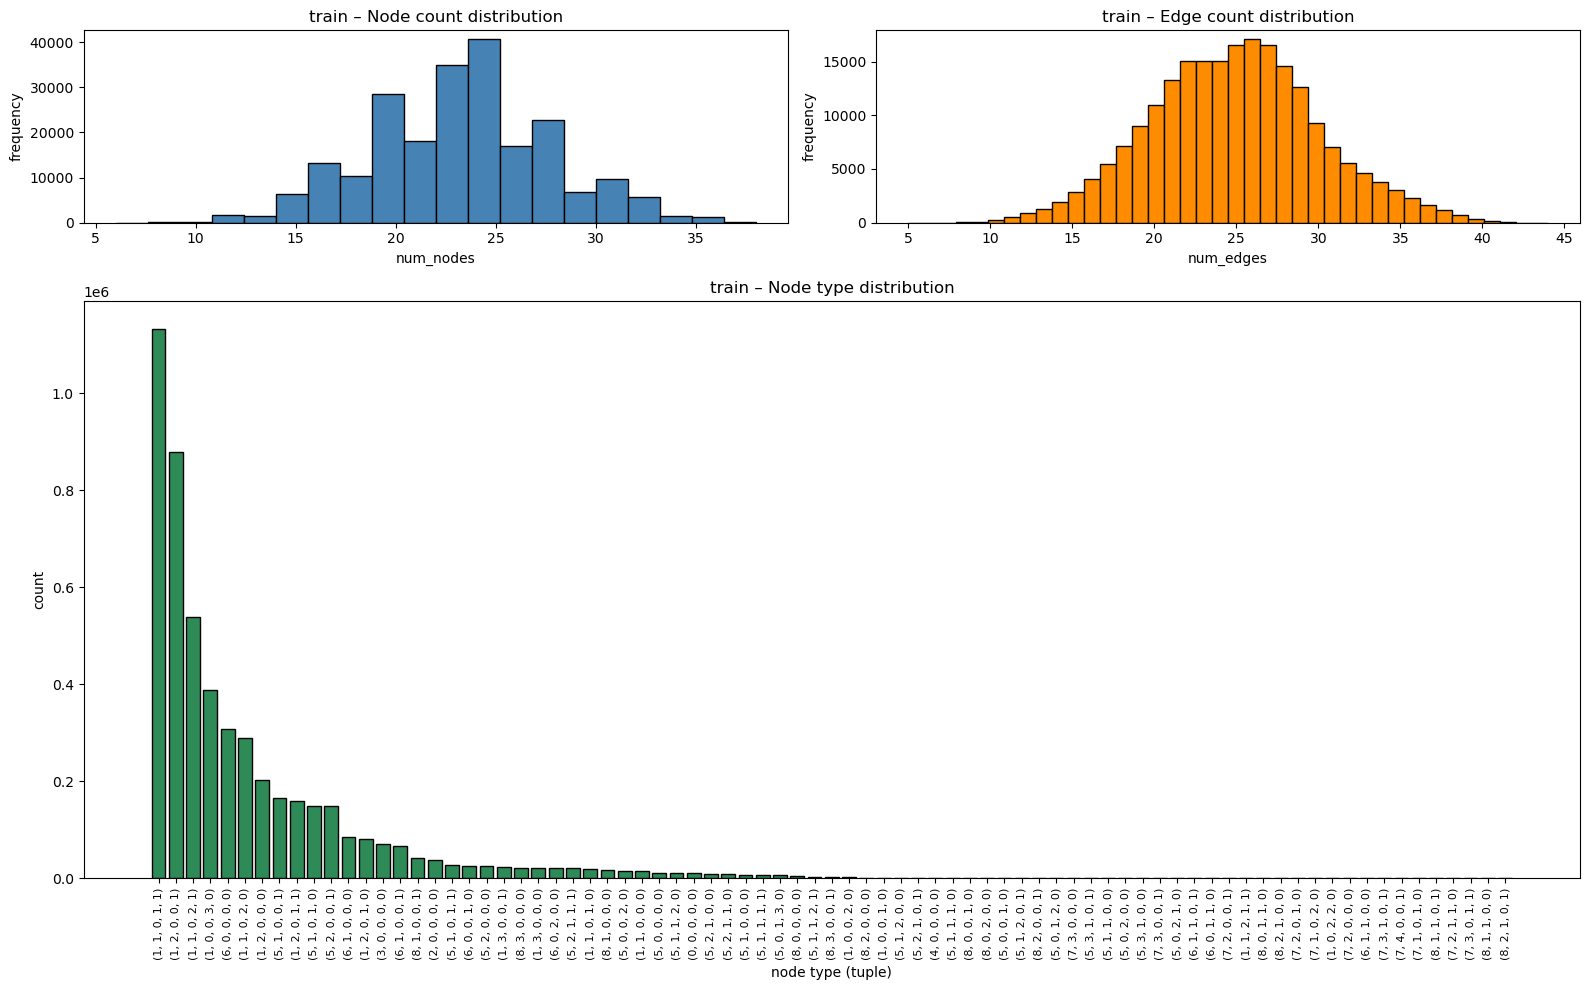

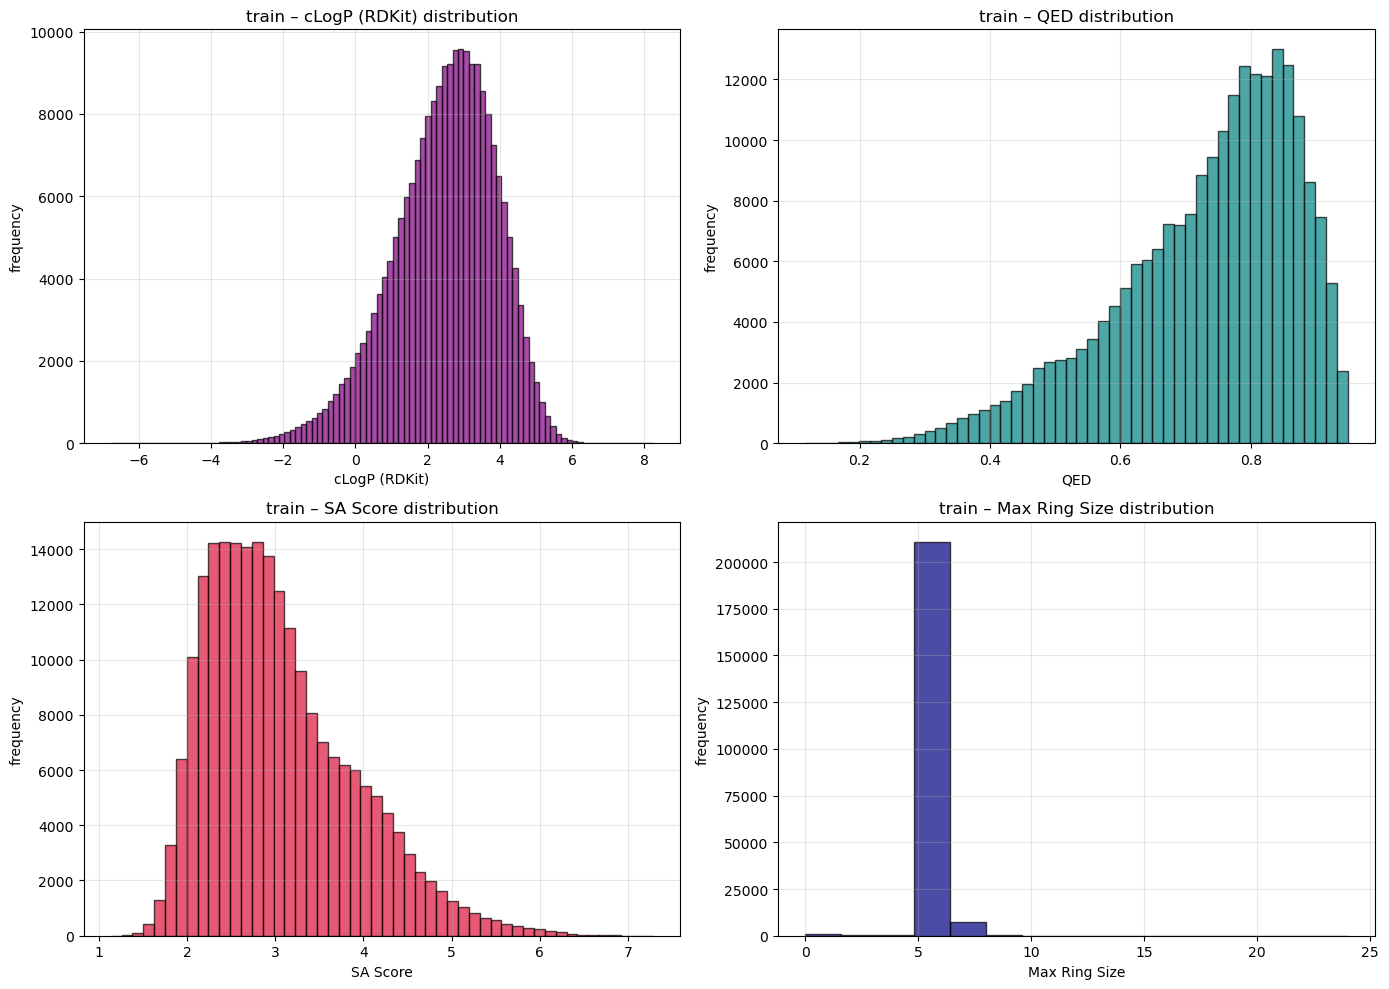

{'dataset': 'train',
 'edges': {'max': 44.0,
           'mean': 24.906559217493673,
           'median': 25.0,
           'min': 5.0,
           'std': 5.2931777992057825},
 'logp': {'max': 8.252099990844727,
          'mean': 2.457799800788871,
          'median': 2.60617995262146,
          'min': -6.771599769592285,
          'std': 1.4334213538628746},
 'max_ring_size': {'max': 24.0,
                   'mean': 5.952266023062483,
                   'median': 6.0,
                   'min': 0.0,
                   'std': 0.522215432228299},
 'node_type_distribution': {(0, 0, 0, 0, 0): 11241,
                            (1, 0, 0, 1, 0): 1147,
                            (1, 0, 0, 2, 0): 2770,
                            (1, 0, 0, 3, 0): 388718,
                            (1, 0, 2, 2, 0): 1,
                            (1, 1, 0, 0, 0): 14353,
                            (1, 1, 0, 1, 0): 18285,
                            (1, 1, 0, 1, 1): 1133197,
                            (1, 1, 0, 2

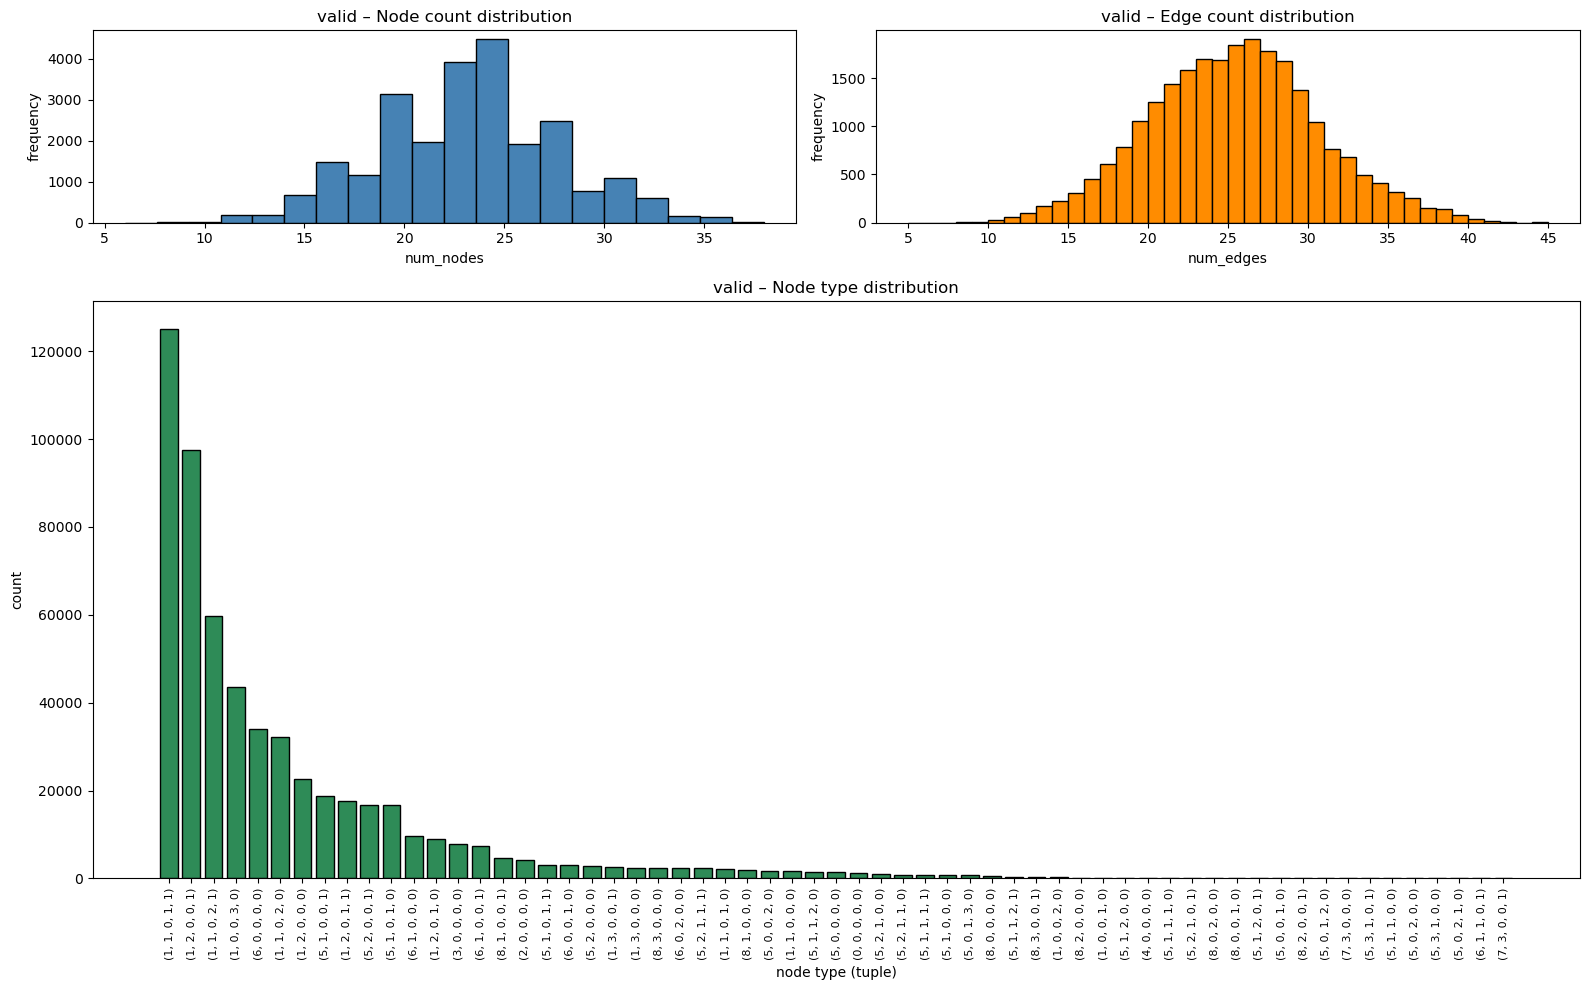

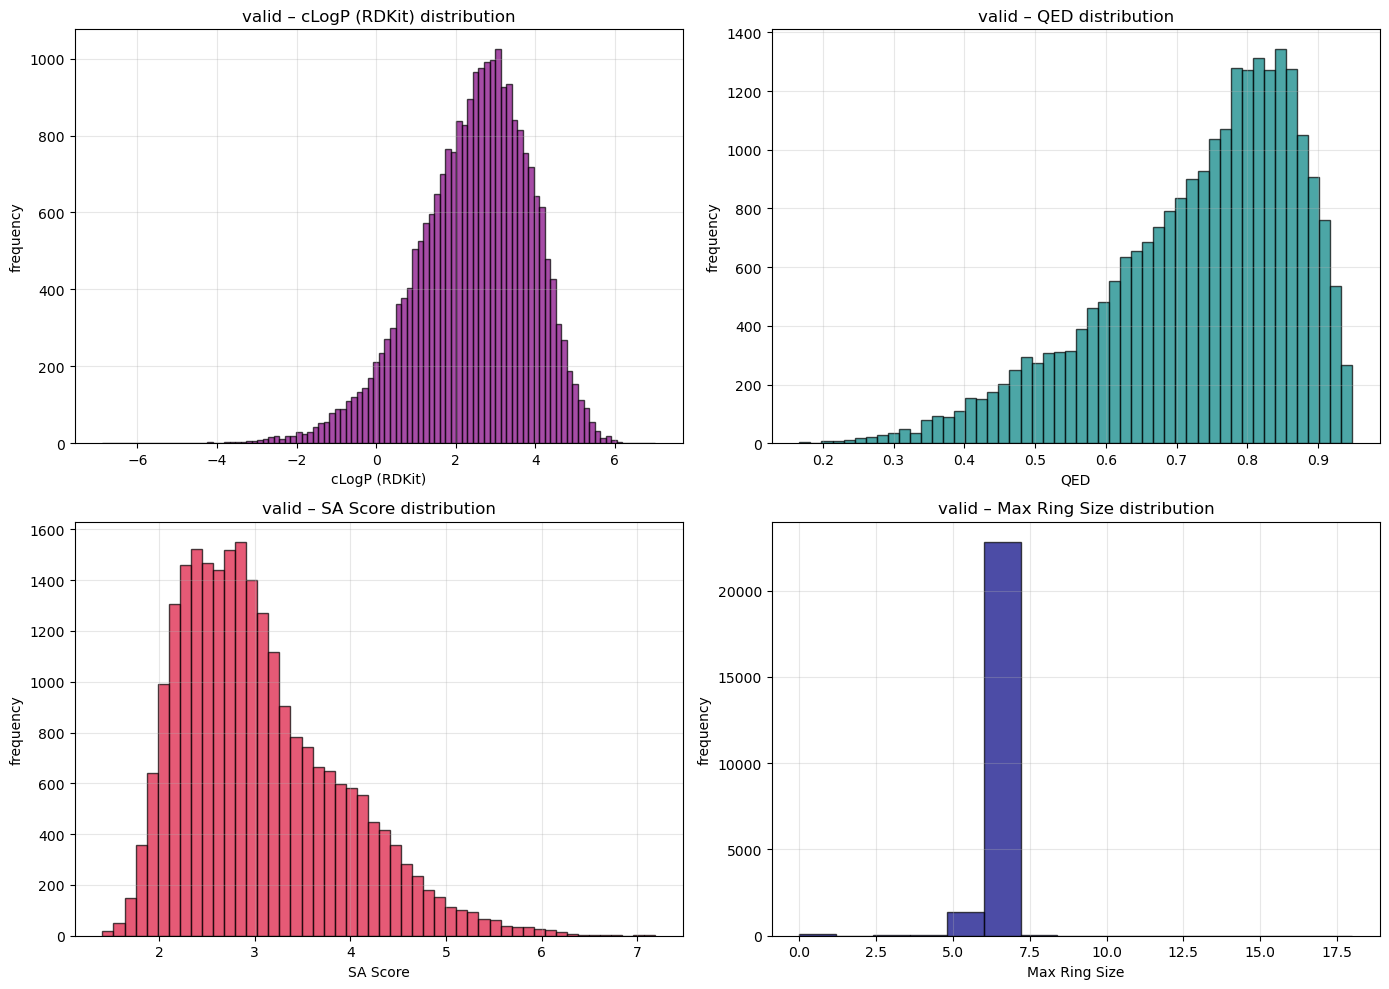

{'dataset': 'valid',
 'edges': {'max': 45.0,
           'mean': 24.87850276130088,
           'median': 25.0,
           'min': 5.0,
           'std': 5.315104283653143},
 'logp': {'max': 7.017499923706055,
          'mean': 2.4467468255596554,
          'median': 2.5975000858306885,
          'min': -6.876200199127197,
          'std': 1.439541991728351},
 'max_ring_size': {'max': 18.0,
                   'mean': 5.945264880343629,
                   'median': 6.0,
                   'min': 0.0,
                   'std': 0.5519473718023836},
 'node_type_distribution': {(0, 0, 0, 0, 0): 1235,
                            (1, 0, 0, 1, 0): 138,
                            (1, 0, 0, 2, 0): 301,
                            (1, 0, 0, 3, 0): 43481,
                            (1, 1, 0, 0, 0): 1603,
                            (1, 1, 0, 1, 0): 2022,
                            (1, 1, 0, 1, 1): 125104,
                            (1, 1, 0, 2, 0): 32259,
                            (1, 1, 0, 2, 

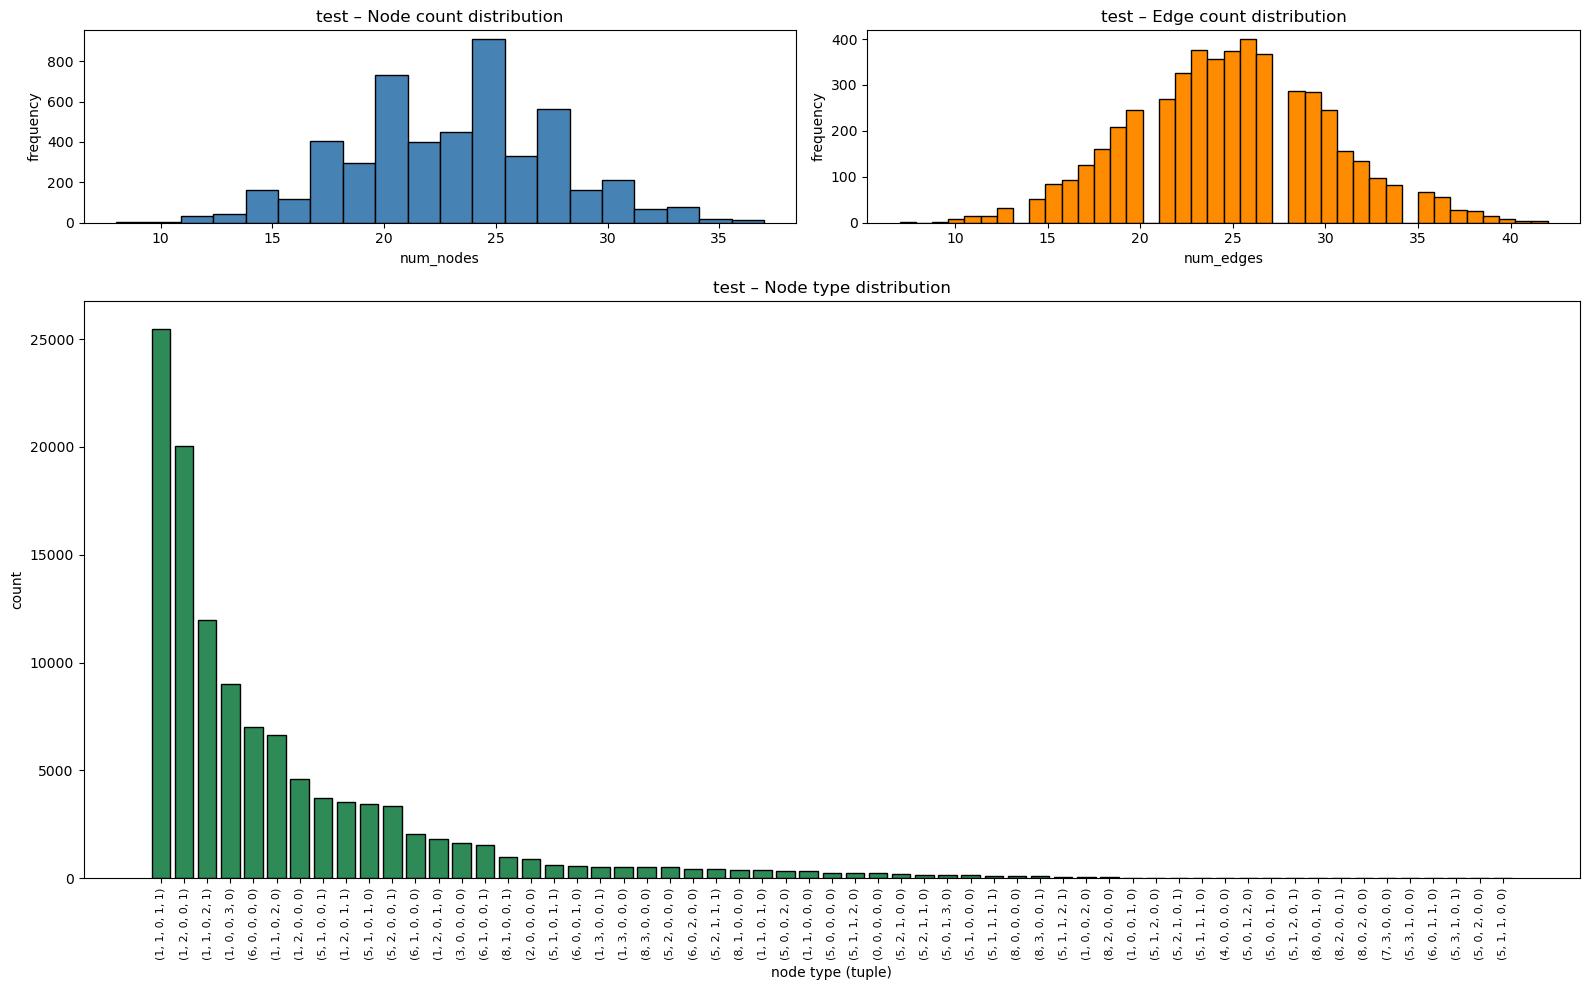

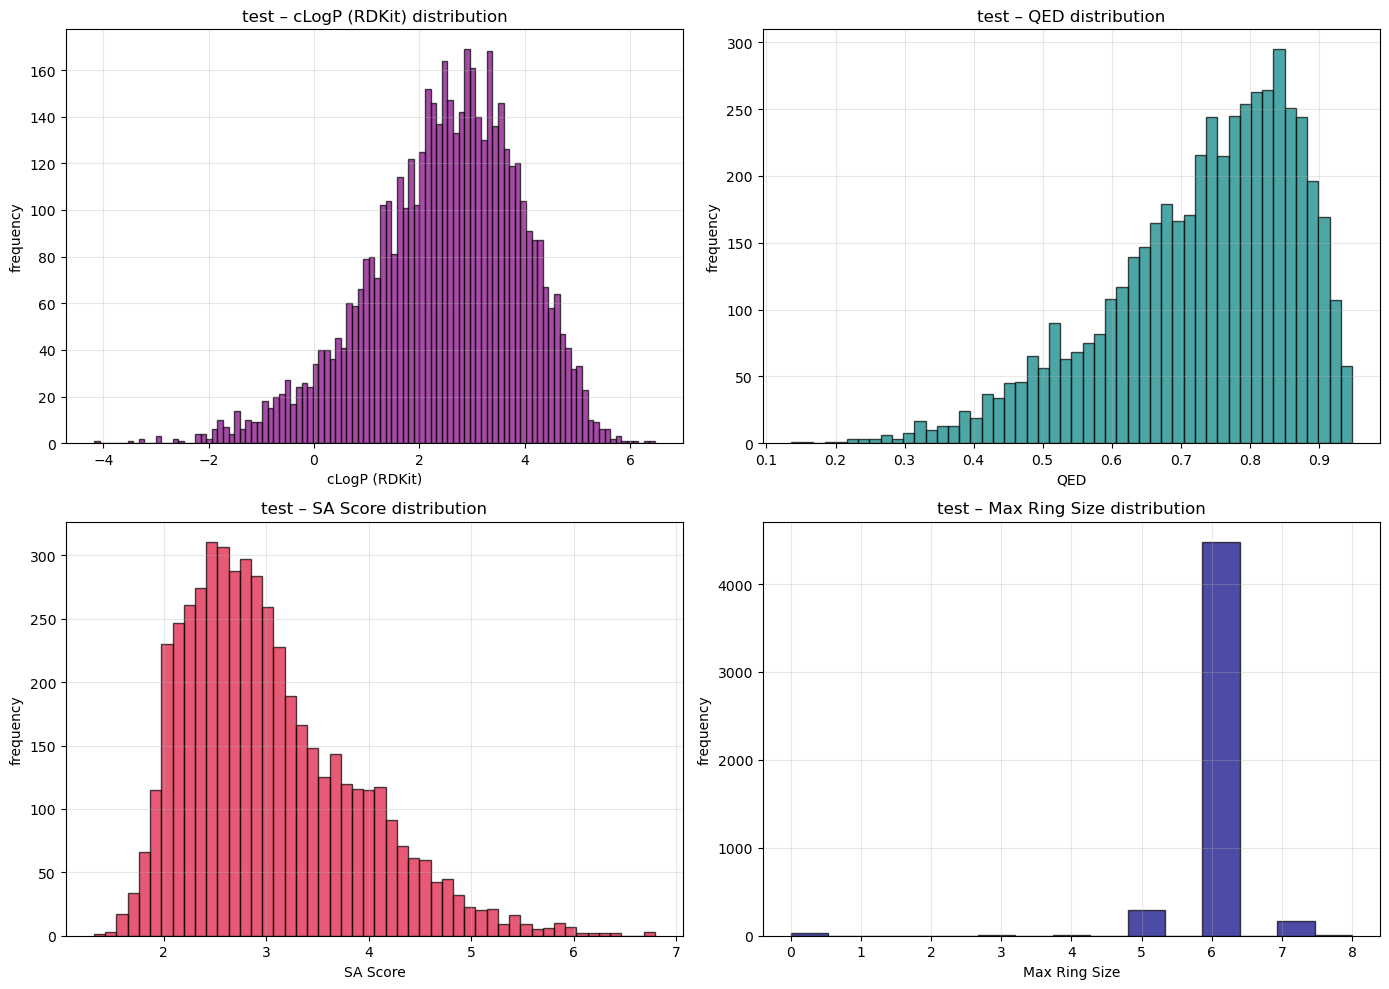

{'dataset': 'test',
 'edges': {'max': 42.0,
           'mean': 24.8302,
           'median': 25.0,
           'min': 7.0,
           'std': 5.31802822903837},
 'logp': {'max': 6.472519874572754,
          'mean': 2.4781004616978577,
          'median': 2.6153000593185425,
          'min': -4.177700042724609,
          'std': 1.4488123376691535},
 'max_ring_size': {'max': 8.0,
                   'mean': 5.9342,
                   'median': 6.0,
                   'min': 0.0,
                   'std': 0.5854390726468096},
 'node_type_distribution': {(0, 0, 0, 0, 0): 246,
                            (1, 0, 0, 1, 0): 31,
                            (1, 0, 0, 2, 0): 67,
                            (1, 0, 0, 3, 0): 9027,
                            (1, 1, 0, 0, 0): 331,
                            (1, 1, 0, 1, 0): 371,
                            (1, 1, 0, 1, 1): 25471,
                            (1, 1, 0, 2, 0): 6661,
                            (1, 1, 0, 2, 1): 11959,
                    

In [2]:
from pprint import pprint
from src.datasets.zinc_smiles_generation import ZincSmiles

total_node_type_dist = set()
for split in ["train", "valid", "test"]:
    ds = ZincSmiles(split=split)
    stats = analyze_dataset(ds, name=split)
    nd_dist = set(stats["node_type_distribution"])
    total_node_type_dist.update(nd_dist)
    pprint(stats)
print(len(total_node_type_dist))